In [1]:
# LTV Prediction using XGBoost and Random Forest

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

LTV                            1.000000
Total_Spent                    0.999949
Avg_Transaction_Value          0.664929
Total_Transactions             0.650863
Max_Transaction_Value          0.540410
Min_Transaction_Value          0.537299
Customer_Satisfaction_Score    0.014858
Age                            0.007645
Loyalty_Points_Earned          0.003852
Issue_Resolution_Time         -0.001180
Last_Transaction_Days_Ago     -0.003382
Cashback_Received             -0.011485
Active_Days                   -0.016738
Referral_Count                -0.023315
Support_Tickets_Raised        -0.029762
Name: LTV, dtype: float64
               Age  Total_Transactions  Max_Transaction_Value  \
count  7000.000000         7000.000000            7000.000000   
mean     42.633714          501.221429           30159.596784   
std      15.516036          286.277311           21996.108793   
min      16.000000            1.000000              31.857484   
25%      29.000000          252.000000           

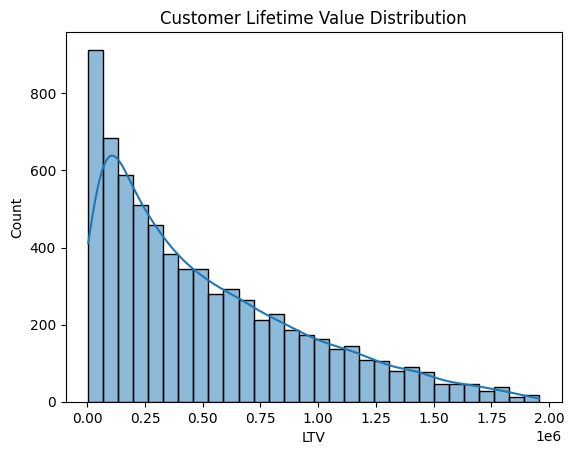

In [2]:
df = pd.read_csv("digital_wallet_ltv_dataset.csv")

correlations = df.corr(numeric_only=True)['LTV'].sort_values(ascending=False)
print(correlations)
df = df.drop(columns=['Total_Spent','Avg_Transaction_Value'])#Total_Spent has corr >0.95, Avg_Transaction_Value is overfitting the model

# Remove rows with no target
df.dropna(subset=['LTV'], inplace=True)

# Fill or drop other missing values
df.fillna(df.median(numeric_only=True), inplace=True)
print(df.describe())
sns.histplot(df['LTV'], kde=True)
plt.title('Customer Lifetime Value Distribution')
plt.show()

In [3]:
# Encode categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))


X = df.drop(columns=['LTV'])
y = df['LTV']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [4]:
# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# XGBoost
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

# Evaluation
def evaluate_model(name, y_true, y_pred):
    print(f"Model: {name}")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print("-" * 30)

evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)

Model: Random Forest
R² Score: 0.9020
RMSE: 138144.56
------------------------------
Model: XGBoost
R² Score: 0.8863
RMSE: 148814.95
------------------------------


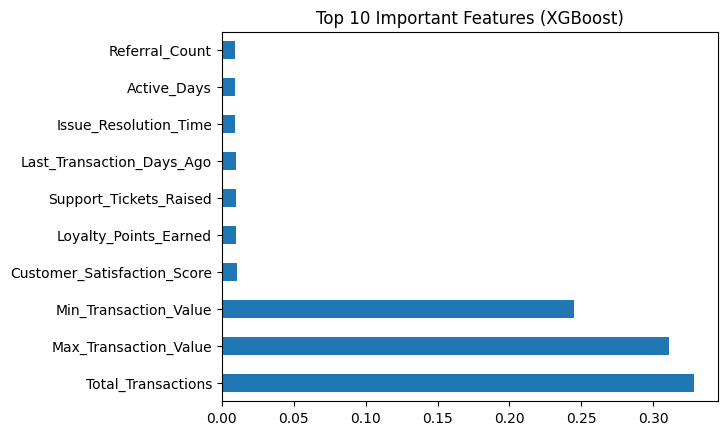

In [5]:
# Feature Importance (XGBoost)
xgb_feat_imp = pd.Series(xgb.feature_importances_, index=df.drop(columns='LTV').columns)
xgb_feat_imp.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features (XGBoost)")
plt.show()

In [6]:
# Export Predictions
output_df = pd.DataFrame({
    'Actual_LTV': y_test,
    'Predicted_LTV_RF': rf_preds,
    'Predicted_LTV_XGB': xgb_preds
})
output_df.to_csv("ltv_predictions.csv", index=False)
print("Predictions saved to ltv_predictions.csv")


Predictions saved to ltv_predictions.csv
